# Project: Explainable COVID-19 Infection Segmentation using LIME and DenseNet201
# Overview
This project demonstrates the use of Explainable Artificial Intelligence (XAI) techniques — specifically LIME (Local Interpretable Model-agnostic Explanations) — to generate interpretable infection localization masks for COVID-19 chest X-ray images.
The base model used for predictions is DenseNet201, a densely connected convolutional neural network known for its high parameter efficiency and strong feature propagation.
DenseNet201’s ability to reuse features across layers makes it well-suited for medical imaging, where subtle intensity variations are crucial for accurate diagnosis.
The main goal is to visualize which regions of the lungs influenced DenseNet121’s COVID-positive predictions, and to generate infection masks that can be compared with ground-truth segmentations or used for model evaluation.

Source: COVID-QU-Ex dataset (segmented chest X-rays with lung masks).

# Workflow Summary
1. Setup and Configuration
Define paths for:
Input X-ray images: /kaggle/input/covid-qu-ex-masked/test/COVID-19
Predicted infection masks (existing dataset): /kaggle/input/predicted-infection-masks
Working output directory: /kaggle/working/predicted_infection_masks/densenet201/test/COVID-19
Initialize the LIME Image Explainer for pixel-level explanations.
Use a pretrained DenseNet201 model (fine-tuned for COVID classification) to define predict_fn — the prediction function required by LIME.
2. Smart Reuse of Existing Predictions
Before running LIME (which is computationally intensive), the script:
Checks if an infection mask for an image already exists in:
/kaggle/working/ → skips it (already generated).
/kaggle/input/predicted-infection-masks/ → copies it to /kaggle/working/.
Only runs LIME for images without an existing mask.
This design allows for incremental, resumable execution — ideal for Kaggle sessions and large datasets.
3. Generating Infection Masks using LIME
For each image that requires prediction:
The image is passed through the DenseNet201 classifier via the predict_fn function.
LIME perturbs the image multiple times (num_samples=1000) to study how pixel-level changes affect the model’s prediction.
The resulting LIME heatmap highlights regions most influential in predicting the COVID-positive label.
The heatmap is converted into a binary infection mask by:
Retaining only positive relevance pixels (those that increase COVID confidence).
Normalizing to [0–1].
Applying a threshold (0.5) to isolate the most relevant regions.
The mask is then restricted to the lung area using the corresponding lung segmentation mask, ensuring only meaningful regions are retained.
The final binary infection mask is saved in the /kaggle/working/ directory.

# Key Features
1. Model-agnostic interpretability: LIME can explain DenseNet201 or any CNN classifier.
2. Automated output management:
Reuses previously predicted masks.
3. Saves only new results.
Organizes outputs neatly under /kaggle/working/.
5. Region restriction: Uses lung masks to ensure infection highlighting is medically grounded.
6. Detailed logging and progress tracking with tqdm

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# load the trained model

In [3]:
import torch
import torch.nn as nn
from torchvision import models

# ==============================
# Check for GPU (T4 expected)
# ==============================
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f" GPU available: {device_name}")
else:
    device_name = "CPU"
    print("GPU not available. Running on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# Define Model Architecture as same as the one used for training
# ==============================
class CovidDenseNet(nn.Module):
    def __init__(self, num_classes=3):
        super(CovidDenseNet, self).__init__()
        self.backbone = models.densenet201(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# ==============================
# Instantiate and Load Weights
# ==============================
model = CovidDenseNet(num_classes=3)

# Path to your Kaggle input directory
# Ensure you've attached the dataset containing chexnet201_finetuned.pth
checkpoint_path = "/kaggle/input/models/models/chexnet201_finetuned.pth"

# Load weights safely (handles both GPU/CPU-trained weights)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)

# Move model to GPU if available
model = model.to(device)
model.eval()

print(f" Model loaded successfully on {device_name} ({device.type})")

 GPU available: Tesla T4


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Model loaded successfully on Tesla T4 (cuda)


In [4]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Loading a test image and predicting for it
img_path = "/kaggle/input/covid-qu-ex-masked/covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: COVID-19
Probabilities: [0.8445820212364197, 0.10296152532100677, 0.05245641618967056]


# performing LIME for a single image

In [5]:
# a common prediction function
def predict_fn(images):
    model.eval()
    images = [transform(Image.fromarray(img)).unsqueeze(0).to(device) for img in images]
    images = torch.cat(images)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

In [6]:
# Load one test image
img_path = "/kaggle/input/covid-qu-ex-masked/covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

# Initialize LIME explainer
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

# Explain prediction
explanation = explainer.explain_instance(
    image_np,          # raw image in numpy
    predict_fn,        # function returning class probabilities
    top_labels=3,      # number of top classes to explain
    hide_color=0,      # background color for masked regions
    num_samples=1000   # number of perturbed samples
)

  0%|          | 0/1000 [00:00<?, ?it/s]

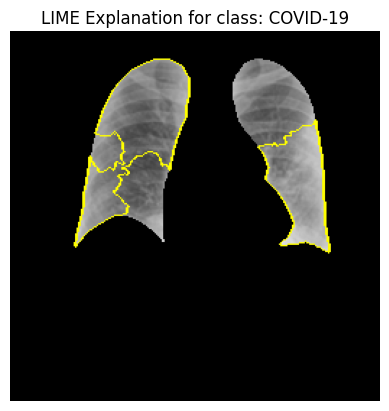

In [7]:
# Pick the class index that was predicted
predicted_label = np.argmax(predict_fn([image_np])[0])

# Get explanation for this label
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=True,
    hide_rest=False,
    num_features=4,       # number of superpixels to highlight
    min_weight=0.01
)

# Plot result
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for class: {classes[predicted_label]}")
plt.axis('off')
plt.show()

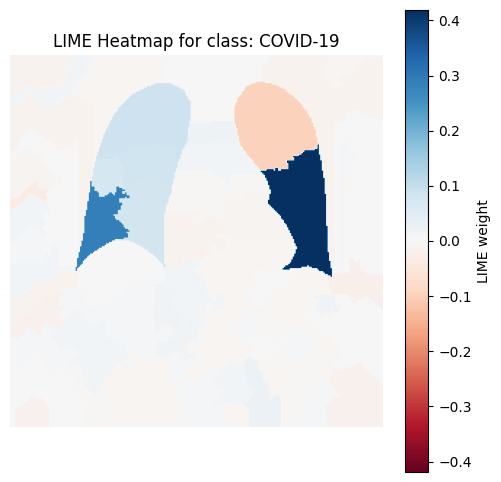

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select the predicted class (same one LIME explained)
ind = explanation.top_labels[0]

# Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

# Plot heatmap with symmetrical colorbar
plt.figure(figsize=(6,6))
plt.imshow(heatmap, cmap='RdBu', vmin=-abs(heatmap).max(), vmax=abs(heatmap).max())
plt.colorbar(label="LIME weight")
plt.title(f"LIME Heatmap for class: {classes[ind]}")
plt.axis("off")
plt.show()

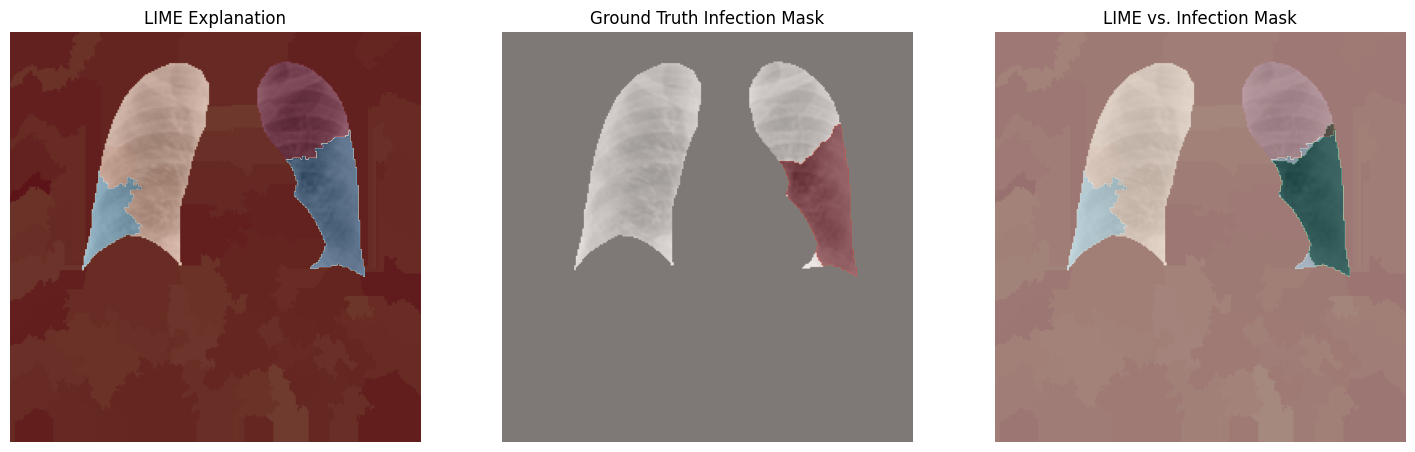

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load original image
original_img = np.array(image)

# Load infection mask (grayscale, then normalize to 0-1)
mask_path = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks/covid_1582.png"
infection_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
infection_mask = cv2.resize(infection_mask, (original_img.shape[1], original_img.shape[0]))
infection_mask = (infection_mask > 0).astype(np.uint8)

# Select the predicted class
ind = explanation.top_labels[0]

# Get LIME weights as heatmap
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original + LIME overlay
axes[0].imshow(original_img, cmap="gray")
axes[0].imshow(heatmap_norm, cmap="RdBu", alpha=0.5)
axes[0].set_title("LIME Explanation")
axes[0].axis("off")

# Original + Infection mask
axes[1].imshow(original_img, cmap="gray")
axes[1].imshow(infection_mask, cmap="Reds", alpha=0.5)
axes[1].set_title("Ground Truth Infection Mask")
axes[1].axis("off")

# Overlay both
axes[2].imshow(original_img, cmap="gray")
axes[2].imshow(heatmap_norm, cmap="RdBu", alpha=0.5)
axes[2].imshow(infection_mask, cmap="Greens", alpha=0.4)
axes[2].set_title("LIME vs. Infection Mask")
axes[2].axis("off")

plt.show()

# Generating infection masks for all the images present in test data

In [10]:
def predict_fn(images):
    model.eval()
    images = [transform(Image.fromarray(img)).unsqueeze(0) for img in images]
    images = torch.cat(images).to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

In [11]:
import os
import cv2
import numpy as np
from PIL import Image
from lime import lime_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil  # for copying files

# ============================================
# Define paths
# ============================================
test_folder = "/kaggle/input/covid-qu-ex-masked/covid_qu_ex_masked/test/COVID-19"
precomputed_root = "/kaggle/input/lime-chexcaps201/LIME+cheXcaps201"
save_root = "/kaggle/working/predicted-infection-masks/predicted_infection_masks/LIME+ChexCaps201"

# Create output directories if they don't exist
os.makedirs(save_root, exist_ok=True)

# ============================================
# Initialize LIME explainer
# ============================================
explainer = lime_image.LimeImageExplainer()

# ============================================
# Get all test image filenames
# ============================================
image_files = [f for f in os.listdir(test_folder) if f.endswith((".png", ".jpg"))]

# ============================================
# Processing all test images
# ============================================
for filename in tqdm(image_files, desc="Generating / Copying LIME infection masks", unit="image"):
    img_path = os.path.join(test_folder, filename)
    precomputed_path = os.path.join(precomputed_root, filename)
    save_path = os.path.join(save_root, filename)
    
    # CASE 1: If mask already exists in save folder → skip
    if os.path.exists(save_path):
        continue

    # CASE 2: If precomputed mask exists in ChexCaps121 folder → copy it
    elif os.path.exists(precomputed_path):
        shutil.copy(precomputed_path, save_path)
        continue

    # CASE 3: Otherwise, generate new mask via LIME
    try:
        # Load image and convert to RGB numpy array
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)

        # Get LIME explanation
        explanation = explainer.explain_instance(
            image_np,
            predict_fn,           # Predefined prediction function
            top_labels=1,         # Use top predicted class
            hide_color=0,
            num_samples=1000
        )

        # Get predicted class
        predicted_label = np.argmax(predict_fn([image_np])[0])

        # Build heatmap for predicted label
        dict_heatmap = dict(explanation.local_exp[predicted_label])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

        # Normalize to [0, 1]
        heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        # Convert to black-and-white mask
        threshold = 0.5
        bw_mask = (heatmap_norm > threshold).astype(np.uint8) * 255

        # Save new mask
        cv2.imwrite(save_path, bw_mask)

    except Exception as e:
        print(f"⚠️ Error processing {filename}: {e}")
        continue

print("✅ All infection masks processed successfully.")


Generating / Copying LIME infection masks: 100%|██████████| 583/583 [00:02<00:00, 200.92image/s]

✅ All infection masks processed successfully.


# Calculating metrics by comparing predicted infection masks with ground truth ones

In [12]:
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 1.0

def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) > 0 else 1.0

def hausdorff_distance(y_true, y_pred):
    true_points = np.column_stack(np.where(y_true))
    pred_points = np.column_stack(np.where(y_pred))
    if len(true_points) == 0 or len(pred_points) == 0:
        return np.nan
    forward_hd = directed_hausdorff(true_points, pred_points)[0]
    backward_hd = directed_hausdorff(pred_points, true_points)[0]
    return max(forward_hd, backward_hd)

def evaluate_mask_metrics(gt_folder, pred_folder):
    gt_files = {f for f in os.listdir(gt_folder) if f.endswith(('.png', '.jpg'))}
    pred_files = {f for f in os.listdir(pred_folder) if f.endswith(('.png', '.jpg'))}

    # Find common filenames present in both folders
    common_files = sorted(list(gt_files & pred_files))

    if not common_files:
        print("No matching filenames found between predicted and ground truth folders.")
        return None

    metrics = {
        'iou': [], 'dice': [], 'accuracy': [],
        'precision': [], 'recall': [], 'f1_score': [], 'hausdorff': []
    }

    for filename in common_files:
        gt_path = os.path.join(gt_folder, filename)
        pred_path = os.path.join(pred_folder, filename)

        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        if gt_mask is None or pred_mask is None:
            continue  # Skip any missing file read
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))

        # Convert to binary 0-1
        gt_mask = (gt_mask > 0).astype(np.uint8)
        pred_mask = (pred_mask > 0).astype(np.uint8)

        gt_flat = gt_mask.flatten()
        pred_flat = pred_mask.flatten()

        metrics['iou'].append(iou_score(gt_mask, pred_mask))
        metrics['dice'].append(dice_score(gt_mask, pred_mask))
        metrics['accuracy'].append(accuracy_score(gt_flat, pred_flat))
        metrics['precision'].append(precision_score(gt_flat, pred_flat, zero_division=0))
        metrics['recall'].append(recall_score(gt_flat, pred_flat, zero_division=0))
        metrics['f1_score'].append(f1_score(gt_flat, pred_flat, zero_division=0))
        metrics['hausdorff'].append(hausdorff_distance(gt_mask, pred_mask))

    avg_metrics = {k: np.nanmean(v) for k, v in metrics.items()}
    return avg_metrics


# Example usage
ground_truth_folder = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks"
predicted_mask_folder = "/kaggle/working/predicted-infection-masks/predicted_infection_masks/LIME+ChexCaps201"

results = evaluate_mask_metrics(ground_truth_folder, predicted_mask_folder)

if results:
    print("Evaluation results for common masks:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

Evaluation results for common masks:
iou: 0.3254
dice: 0.4566
accuracy: 0.8547
precision: 0.5532
recall: 0.5135
f1_score: 0.4566
hausdorff: 94.3235


# Conclusion
This notebook demonstrates an explainable AI pipeline that integrates DenseNet201 with LIME-based interpretability for COVID-19 infection localization.
By overlaying LIME explanations on lung-segmented chest X-rays, it produces transparent and medically meaningful infection masks.
This approach enhances model interpretability, supports clinical insights, and builds trust in AI-driven diagnostic tools.

To download the predicted infection masks, run next cell then download by clicking three dots on the dataset in the output section

In [13]:
import shutil
import os

# Path where all masks are stored
working_mask_root = "/kaggle/working/predicted-infection-masks/predicted_infection_masks/LIME+ChexCaps201"

# Output zip file path
zip_path = "/kaggle/working/predicted_infection_masks_cheXcaps201.zip"

# Create the zip archive
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', working_mask_root)

# Confirm
num_files = len(os.listdir(working_mask_root))
print(f"✅ Successfully zipped {num_files} infection masks.")
print(f"📦 Zip file created at: {zip_path}")
print("📥 You can now download it from the right-hand 'Files' tab in Kaggle → predicted_infection_masks_convnext.zip")


✅ Successfully zipped 583 infection masks.
📦 Zip file created at: /kaggle/working/predicted_infection_masks_cheXcaps201.zip
📥 You can now download it from the right-hand 'Files' tab in Kaggle → predicted_infection_masks_convnext.zip
